Using device: cpu
Training set size: 60000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


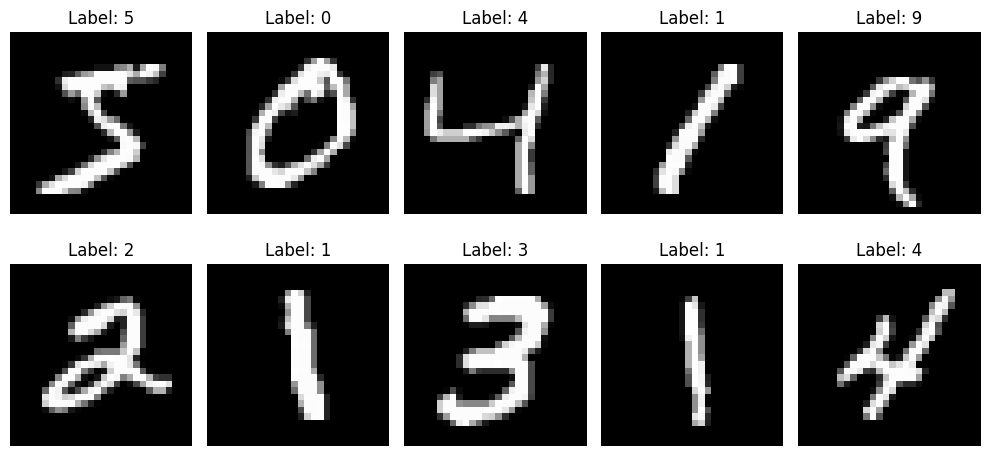

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from tqdm.notebook import tqdm

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)


# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Show dataset information
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")

# Display some sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    plt.title(f"Label: {train_dataset[i][1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Projection layer: from patches to embedding dim
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        
    def forward(self, x):
        # x: (batch_size, channels, img_size, img_size)
        batch_size = x.shape[0]
        x = self.proj(x)  # (batch_size, embed_dim, n_patches^0.5, n_patches^0.5)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=64, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        self.scale = self.head_dim ** -0.5  # Scaling factor
        
        # QKV projections in a single layer
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        
        # Output projection
        self.proj = nn.Linear(embed_dim, embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, n_tokens, embed_dim = x.shape
        
        # Get query, key, value projections
        qkv = self.qkv(x)  # (batch_size, n_tokens, embed_dim*3)
        qkv = qkv.reshape(batch_size, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, n_heads, n_tokens, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale  # (batch_size, n_heads, n_tokens, n_tokens)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        out = (attn @ v)  # (batch_size, n_heads, n_tokens, head_dim)
        out = out.transpose(1, 2)  # (batch_size, n_tokens, n_heads, head_dim)
        out = out.reshape(batch_size, n_tokens, embed_dim)  # (batch_size, n_tokens, embed_dim)
        
        # Output projection
        out = self.proj(out)
        out = self.dropout(out)
        
        return out

class MLP(nn.Module):
    """
    Multi-layer perceptron for feature extraction
    """
    def __init__(self, in_features, hidden_features, out_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)  # GELU activation
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):

    def __init__(self, embed_dim=64, n_heads=4, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            embed_dim,
            int(embed_dim * mlp_ratio),
            embed_dim,
            dropout
        )
        
    def forward(self, x):
        # First attention block with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP block with residual connection
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self, 
        img_size=28, 
        patch_size=7, 
        in_channels=1, 
        n_classes=10,
        embed_dim=64, 
        depth=6, 
        n_heads=4, 
        mlp_ratio=4.0, 
        dropout=0.1
    ):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches
        
        # Class token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Layer normalization and classifier head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        # Initialize patch embeddings
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        
        # Apply to all Linear layers
        self.apply(self._init_weights_layer)
    
    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            # Use standard normal initialization
            nn.init.normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
            
    def forward(self, x):
        # Get batch size
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embed(x)  # (batch_size, n_patches, embed_dim)
        
        # Add class token
        cls_token = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (batch_size, n_patches + 1, embed_dim)
        
        # Add position embeddings
        x = x + self.pos_embed  # (batch_size, n_patches + 1, embed_dim)
        
        # Apply Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply final normalization
        x = self.norm(x)
        
        # Use [CLS] token for classification
        x = x[:, 0]  # (batch_size, embed_dim)
        
        # Classification head
        x = self.head(x)  # (batch_size, n_classes)
        
        return x

# Create model and move to device
model = VisionTransformer(
    img_size=28,
    patch_size=7,  # This creates 4x4=16 patches (plus cls token)
    in_channels=1,
    n_classes=10,
    embed_dim=64,
    depth=6,
    n_heads=4,
    mlp_ratio=4.0,
    dropout=0.1
)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

# Test with a sample input
sample = torch.randn(2, 1, 28, 28).to(device)
output = model(sample)
print(f"Sample output shape: {output.shape}")

Model parameters: 305034
VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 64, kernel_size=(7, 7), stride=(7, 7))
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=64, out_features=10, bias=True)
)
Sample output shape: torch.Size([2, 10])


Epoch 1/10
Training batch: 1/469 (0.2%)
Training batch: 11/469 (2.3%)
Training batch: 21/469 (4.5%)
Training batch: 31/469 (6.6%)
Training batch: 41/469 (8.7%)
Training batch: 51/469 (10.9%)
Training batch: 61/469 (13.0%)
Training batch: 71/469 (15.1%)
Training batch: 81/469 (17.3%)
Training batch: 91/469 (19.4%)
Training batch: 101/469 (21.5%)
Training batch: 111/469 (23.7%)
Training batch: 121/469 (25.8%)
Training batch: 131/469 (27.9%)
Training batch: 141/469 (30.1%)
Training batch: 151/469 (32.2%)
Training batch: 161/469 (34.3%)
Training batch: 171/469 (36.5%)
Training batch: 181/469 (38.6%)
Training batch: 191/469 (40.7%)
Training batch: 201/469 (42.9%)
Training batch: 211/469 (45.0%)
Training batch: 221/469 (47.1%)
Training batch: 231/469 (49.3%)
Training batch: 241/469 (51.4%)
Training batch: 251/469 (53.5%)
Training batch: 261/469 (55.7%)
Training batch: 271/469 (57.8%)
Training batch: 281/469 (59.9%)
Training batch: 291/469 (62.0%)
Training batch: 301/469 (64.2%)
Training batc

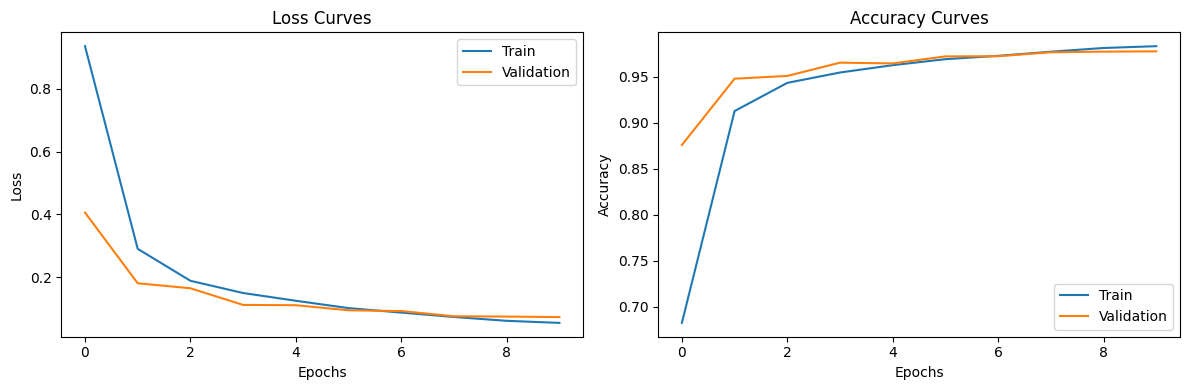

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Simple progress printing function instead of tqdm
def progress_print(current, total, message="", frequency=10):
    if current % frequency == 0 or current == total - 1:
        print(f"{message}: {current+1}/{total} ({(current+1)/total*100:.1f}%)")

# Training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(dataloader):
        # Simple progress reporting
        progress_print(i, len(dataloader), "Training batch")
        
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Evaluation loop
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            # Simple progress reporting
            progress_print(i, len(dataloader), "Evaluating batch", frequency=20)
            
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Train the model
num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Create test dataloader for validation during training
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
best_val_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_mnist.pth')
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)

# Total training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

The model reached very IDEAL accuracy with only a few minutes of training! The vision transformer workes very well on the MNIST dataset, which is as expected.

*Towards a quantum vision transformer:

A Quantum Vision Transformer (QViT) should combine classical image processing with quantum computing to improve image classification. Here are the elements that can be replaced by quantum computation methods.

1.Encoding:Use classical image patching and embedding. These patches are then encoded into quantum states using amplitude encoding or angle embedding techniques on a small register of qubits (4-8 per patch).

2.Quantum self-attention mechanism. Rather than computing attention through matrix multiplication, attention scores are generated by parameterized quantum circuits. Two-qubit entangling operations (CNOT gates) create correlations between different elements, potentially capturing more complex relationships than classical methods. Measurement operators extract the final attention scores.

3.The MLP blocks can similarly be replaced with variational quantum circuits, implementing non-linear transformations through sequences of rotation and entanglement operations. A classical layernorm is maintained for training stability.

*Training: 
Gradients are estimated using parameter-shift rules on quantum operations, allowing the model to learn through standard optimization techniques.

For practical implementation, a resource-efficient design processes patches sequentially on the same quantum hardware. Classical skip connections preserve gradient flow, while the embedding and final classification layers remain classical to reduce quantum resource requirements.

The primary advantages may come from quantum superposition enabling efficient feature space exploration and entanglement creating correlations between distant image regions. However, current hardware limitations present implementation challenges. A minimal viable QViT would focus quantum resources on the self-attention mechanism while keeping other components classical until quantum hardware matures.